In [2]:
# load packages
library(survival)
library(ggplot2)
library(survminer)
library(drc)
library(tidyverse)
library(coxphf)

In [4]:
dose_data <- read.csv("drc.csv")
str(dose_data)

'data.frame':	300 obs. of  29 variables:
 $ bee_code : chr  "Hive1_C0_1" "Hive1_C0_2" "Hive1_C0_3" "Hive1_C0_4" ...
 $ pot_code : chr  "Hive1_C0" "Hive1_C0" "Hive1_C0" "Hive1_C0" ...
 $ hive     : int  1 1 1 1 1 1 1 1 1 1 ...
 $ dose     : int  0 0 0 0 0 0 0 0 0 0 ...
 $ treatment: chr  "0 spores  " "0 spores  " "0 spores  " "0 spores  " ...
 $ day_0    : int  1 1 1 1 1 1 1 1 1 1 ...
 $ day_1    : int  1 1 1 1 1 1 1 1 1 1 ...
 $ day_2    : int  1 1 1 1 1 1 1 1 1 1 ...
 $ day_3    : int  1 1 1 1 1 1 1 1 1 1 ...
 $ day_4    : int  1 1 1 1 1 1 1 1 1 1 ...
 $ day_5    : int  1 1 1 1 1 1 1 1 1 1 ...
 $ day_6    : int  1 1 1 1 1 1 1 1 1 1 ...
 $ day_7    : int  1 1 1 1 1 1 1 1 1 1 ...
 $ day_8    : int  1 1 1 1 1 1 1 1 1 1 ...
 $ day_9    : int  1 1 1 1 1 1 1 1 1 1 ...
 $ day_10   : int  1 1 1 1 1 1 1 1 1 1 ...
 $ day_11   : int  1 1 1 1 1 1 1 1 1 1 ...
 $ day_12   : int  1 1 1 1 1 1 1 1 1 1 ...
 $ day_13   : int  1 1 1 1 1 1 1 1 1 1 ...
 $ day_14   : int  1 1 1 1 1 1 1 1 1 1 ...
 $ day_15  

In [5]:
head(dose_data)

,bee_code,pot_code,hive,dose,treatment,day_0,day_1,day_2,day_3,day_4,⋯,day_14,day_15,day_16,day_17,dod7,event7,dod9,event9,dod17,event17
,<chr>,<chr>,<int>,<int>,<chr>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,Hive1_C0_1,Hive1_C0,1,0,0 spores,1,1,1,1,1,⋯,1,1,1,1,7,0,9,0,17,0
2,Hive1_C0_2,Hive1_C0,1,0,0 spores,1,1,1,1,1,⋯,1,1,1,1,7,0,9,0,17,0
3,Hive1_C0_3,Hive1_C0,1,0,0 spores,1,1,1,1,1,⋯,1,1,1,1,7,0,9,0,17,0
4,Hive1_C0_4,Hive1_C0,1,0,0 spores,1,1,1,1,1,⋯,1,1,1,1,7,0,9,0,17,0
5,Hive1_C0_5,Hive1_C0,1,0,0 spores,1,1,1,1,1,⋯,1,1,1,1,7,0,9,0,17,0
6,Hive1_C0_6,Hive1_C0,1,0,0 spores,1,1,1,1,1,⋯,1,1,1,1,7,0,9,0,17,0


## 1. Create propertional dataframe collapsed by pot

In [9]:
# group data by pot
dose.pot <- subset(dose_data, select = -c(bee_code, dod7, event7, dod9, event9, dod17, event17))
dose.pot <- dose.pot %>% group_by(treatment, dose, hive, pot_code) %>% summarise_all(list(sum))

# convert frequencies to proportions
dose.pot[, -(1:4)] <- sweep(dose.pot[, -(1:4)], unlist(dose.pot[, "day_0"]), MARGIN = 1, "/")
dose.pot

treatment,dose,hive,pot_code,day_0,day_1,day_2,day_3,day_4,day_5,⋯,day_8,day_9,day_10,day_11,day_12,day_13,day_14,day_15,day_16,day_17
<chr>,<int>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0 spores,0,1,Hive1_C0,1,1.00,1.00,1.00,1.00,1.00,⋯,1.00,1.00,1.00,1.00,1.0000000,1.0000000,1.0000000,1.0000000,1.0000000,0.9500000
0 spores,0,2,Hive2_C0,1,1.00,1.00,1.00,1.00,1.00,⋯,1.00,1.00,1.00,1.00,1.0000000,1.0000000,1.0000000,0.8000000,0.7500000,0.7500000
0 spores,0,3,Hive3_C0,1,1.00,1.00,1.00,1.00,1.00,⋯,1.00,1.00,1.00,1.00,1.0000000,1.0000000,1.0000000,1.0000000,1.0000000,1.0000000
200 spores,200,1,Hive1_N200,1,1.00,1.00,0.95,0.95,0.85,⋯,0.80,0.75,0.75,0.75,0.7500000,0.7500000,0.7000000,0.6000000,0.4000000,0.3500000
200 spores,200,2,Hive2_N200,1,1.00,1.00,1.00,1.00,1.00,⋯,1.00,1.00,1.00,1.00,1.0000000,0.9500000,0.9500000,0.9500000,0.7500000,0.7500000
200 spores,200,3,Hive3_N200,1,1.00,1.00,1.00,1.00,1.00,⋯,1.00,1.00,1.00,1.00,1.0000000,0.9500000,0.9500000,0.9500000,0.9000000,0.8000000
200 spores,2000,1,Hive1_N2000,1,1.00,1.00,1.00,1.00,1.00,⋯,0.00,0.00,0.00,0.00,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000
2000 spores,2000,1,Hive1_N2000,1,1.00,1.00,1.00,1.00,1.00,⋯,1.00,1.00,1.00,1.00,0.9473684,0.8421053,0.7368421,0.5789474,0.5789474,0.4736842
2000 spores,2000,2,Hive2_N2000,1,1.00,1.00,1.00,0.95,0.95,⋯,0.95,0.95,0.95,0.95,0.9500000,0.9000000,0.8000000,0.6500000,0.6500000,0.6500000


## 2. Make summary survival tables from the pot tables

In [11]:
# now all the calculations are done, we can make a survival table to display the data
dose.pot.sum = subset(dose.pot, select = -c(dose, hive, pot_code))
dose.pot.sum <- dose.pot.sum %>% group_by(treatment) %>% summarise_all(list(mean))
dose.pot.sum

treatment,day_0,day_1,day_2,day_3,day_4,day_5,day_6,day_7,day_8,day_9,day_10,day_11,day_12,day_13,day_14,day_15,day_16,day_17
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0 spores,1,1.0000000,1.0000000,1.0000000,1.0000000,1.0000000,1.0000000,1.0000000,1.0000000,1.0000000,1.0000000,1.0000000,1.0000000,1.0000000,1.0000000,0.9333333,0.9166667,0.9000000
200 spores,1,1.0000000,1.0000000,0.9875000,0.9875000,0.9625000,0.9500000,0.7000000,0.7000000,0.6875000,0.6875000,0.6875000,0.6875000,0.6625000,0.6500000,0.6250000,0.5125000,0.4750000
2000 spores,1,0.9833333,0.9833333,0.9833333,0.9500000,0.9500000,0.9333333,0.9333333,0.9333333,0.9333333,0.9333333,0.9333333,0.9157895,0.8640351,0.7956140,0.6596491,0.6429825,0.6078947
20000 spores,1,0.9833333,0.9833333,0.9833333,0.9833333,0.9833333,0.9666667,0.9666667,0.9666667,0.9500000,0.9500000,0.9500000,0.9333333,0.9333333,0.8666667,0.8166667,0.8000000,0.7333333
200000 spores,1,0.9833333,0.9833333,0.9833333,0.9833333,0.9833333,0.9500000,0.9500000,0.9500000,0.9500000,0.9500000,0.9500000,0.9500000,0.9166667,0.8833333,0.8000000,0.7000000,0.6166667


## 3. Plotting the survival probability data (first, 17 days)

In [14]:
# run fit function plots to look at the data
survfit.17 <- survfit(Surv(dod17, event17) ~ treatment, data = dose_data)

Warning message in .add_surv_median(p, fit, type = surv.median.line, fun = fun, :
“Median survival not reached.”


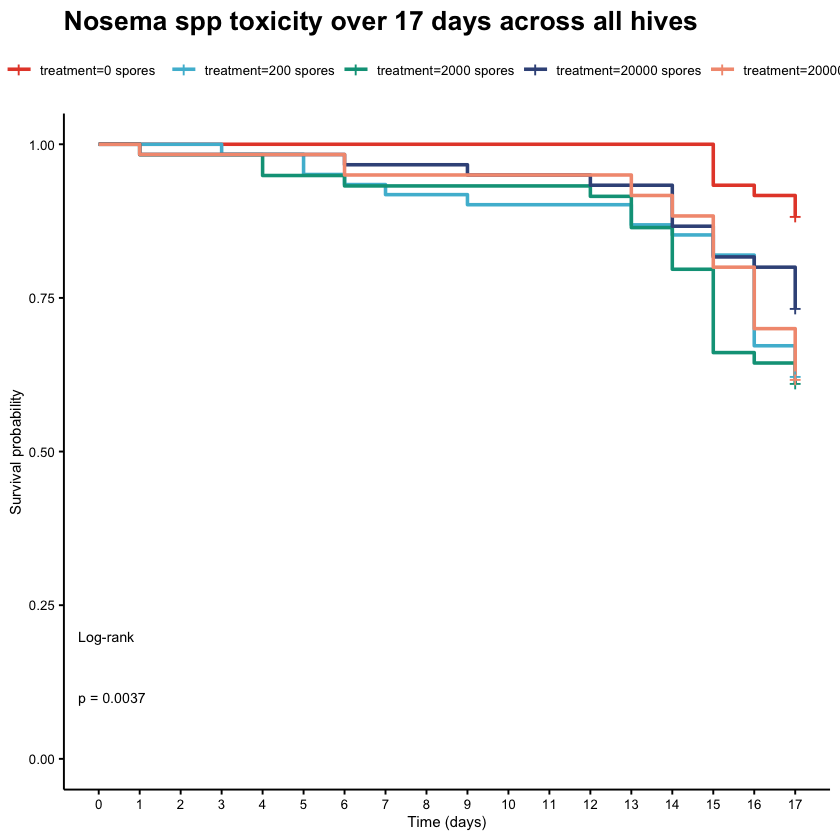

In [15]:
# list and format ggsurvplots as an overall figure
overall.km.17 <- ggsurvplot(survfit.17, data = dose_data, pval = TRUE, pval.size =3, pval.method = TRUE,
                            pval.coord = c(-0.5, 0.1), pval.method.size = 3, pval.method.coord = c(-0.5, 0.2),
                            title = "Nosema spp toxicity over 17 days across all hives", font.main = c(16, "bold"), font.y = 9,
                            font.x =9, font.tickslab = 8, xlab = "Time (days)", font.legend=8, legend.tabs =
                            c("0 spores", "200 spores", "2000 spores", "20000 spores", "200000 spores"), 
                            legend.title = "", time.inc = 2, xlim = c(0,17), palette = "npg", linetype = "solid", 
                            surv.median.line = "h", legend = "top", break.time.by = 1)
overall.km.17
# 2000 spores achieved the highest death rate than other treatments, and 200 was second highest

## 4. Statistical comparison of the treatments

In [16]:
# assign survival formulas for the cox proportional hazards. Include Hive as additive first and then as interaction

dose.coxph.17 <- coxph(Surv(dod17, event17) ~ treatment + hive, data=dose_data)
dose.coxph.17

In [19]:
# validate that data meets assumptions of cox proportional hazards
validate_coxph.mod17 = cox.zph(dose.coxph.17)
validate_coxph.mod17.interact = cox.zph(dose.coxph.17.interact)
# not violating the assumtions

          chisq df    p
treatment 5.680  4 0.22
hive      0.617  1 0.43
GLOBAL    6.472  5 0.26

                chisq df     p
treatment       6.676  4 0.154
hive            0.784  1 0.376
treatment:hive  8.095  4 0.088
GLOBAL         12.626  9 0.180

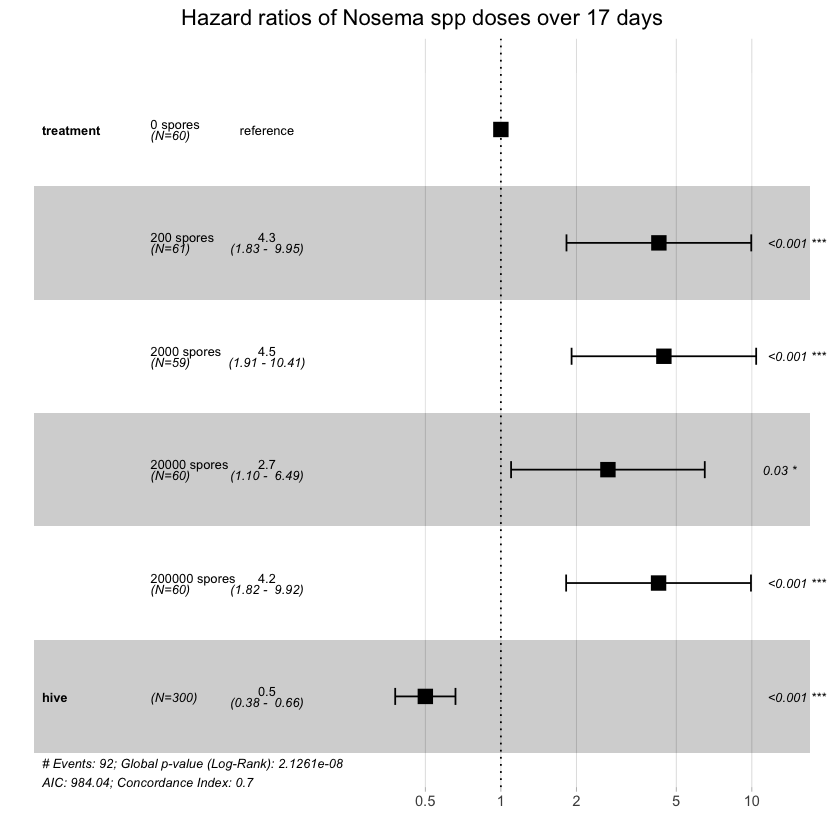

In [21]:
ggforest.dose.17 <- ggforest(dose.coxph.17, data = dose_data, cpositions = c(0.01, 0.15, 0.3), main = 
                              "Hazard ratios of Nosema spp doses over 17 days")
ggforest.dose.17

In [23]:
# now try with interaction 
dose.coxph.17.interact <- coxph(Surv(dod17, event17) ~ treatment * hive, data=dose_data)
dose.coxph.17.interact

Call:
coxph(formula = Surv(dod17, event17) ~ treatment * hive, data = dose_data)

                               coef exp(coef) se(coef)      z       p
treatment200 spores          2.7091   15.0155   1.0611  2.553 0.01067
treatment2000 spores         1.7389    5.6910   1.0674  1.629 0.10331
treatment20000 spores        1.4425    4.2314   1.1218  1.286 0.19847
treatment200000 spores       3.0516   21.1487   1.0673  2.859 0.00425
hive                        -0.2092    0.8112   0.4580 -0.457 0.64780
treatment200 spores:hive    -0.7495    0.4726   0.5454 -1.374 0.16938
treatment2000 spores:hive   -0.1464    0.8638   0.5277 -0.277 0.78141
treatment20000 spores:hive  -0.2686    0.7644   0.5633 -0.477 0.63344
treatment200000 spores:hive -0.9735    0.3777   0.5602 -1.738 0.08223

Likelihood ratio test=50.65  on 9 df, p=8.131e-08
n= 300, number of events= 92 

In [25]:
# check we don't violate assumptions
validate_coxph.mod17.interact = cox.zph(dose.coxph.17.interact)
validate_coxph.mod17.interact
# not violating the assumtions

                chisq df     p
treatment       6.676  4 0.154
hive            0.784  1 0.376
treatment:hive  8.095  4 0.088
GLOBAL         12.626  9 0.180

In [26]:
# non-signif hive interaction effect when hives are grouped together. And when run as an
# interaction model, lots of the treatments effects become non-signif. So seems there is not an interactive effect

## 5. Dose response curve - selecting a model

In [29]:
dose.17.m0 <- drm(day_17 ~ dose, data = dose.pot, fct = LL.4(names = c('Slope', 'Lower Limit (Infinate_dose_surv',
                                                                  'Upper Limit (Control_surv)', 'LC50')))
# selecting the best model
mselect(dose.17.m0, list(LL.3(), LL.5(), W1.3(), W1.4(), W2.4(), baro5()))
# W2.4 looks like the best model

Warning message in sqrt(diag(varMat)):
“NaNs produced”
Warning message in sqrt(diag(varMat)):
“NaNs produced”


Error in optim(startVec, opfct, hessian = TRUE, method = optMethod, control = list(maxit = maxIt,  : 
  non-finite finite-difference value [4]


Warning message in sqrt(diag(varMat)):
“NaNs produced”


Error in optim(startVec, opfct, hessian = TRUE, method = optMethod, control = list(maxit = maxIt,  : 
  initial value in 'vmmin' is not finite


,logLik,IC,Lack of fit,Res var
W2.4,0.3817845,9.236431,0.1759536914,0.07442837
LL.3,-0.7401910,9.480382,0.1774684335,0.07904691
LL.4,-0.7430524,11.486105,0.0687619144,0.08566478
W1.4,-3.3823997,16.764799,0.0091494951,0.11914727
W1.3,-10.0975505,28.195101,0.0002852493,0.25460451
LL.5,NA,NA,NA,NA
baro5,NA,NA,NA,NA


In [31]:
dose.17.m0 <- drm(day_17 ~ dose, data = dose.pot, fct = W2.4(names = c('Slope', 'Lower Limit (Infinate_dose_surv',
                                                                  'Upper Limit (Control_surv)', 'LC50')))

## 6. Creating the dose response curve

In [32]:
# to create the curve and establish an LD50 we need to get a summary of the model
summary(dose.17.m0)


Model fitted: Weibull (type 2) (4 parms)

Parameter estimates:

                                               Estimate Std. Error t-value
Slope:(Intercept)                           -6.9982e-05         NA      NA
Lower Limit (Infinate_dose_surv:(Intercept)  2.1038e-02         NA      NA
Upper Limit (Control_surv):(Intercept)       9.1865e-01         NA      NA
LC50:(Intercept)                             1.6580e+06         NA      NA
                                            p-value
Slope:(Intercept)                                NA
Lower Limit (Infinate_dose_surv:(Intercept)      NA
Upper Limit (Control_surv):(Intercept)           NA
LC50:(Intercept)                                 NA

Residual standard error:

 0.2728156 (12 degrees of freedom)

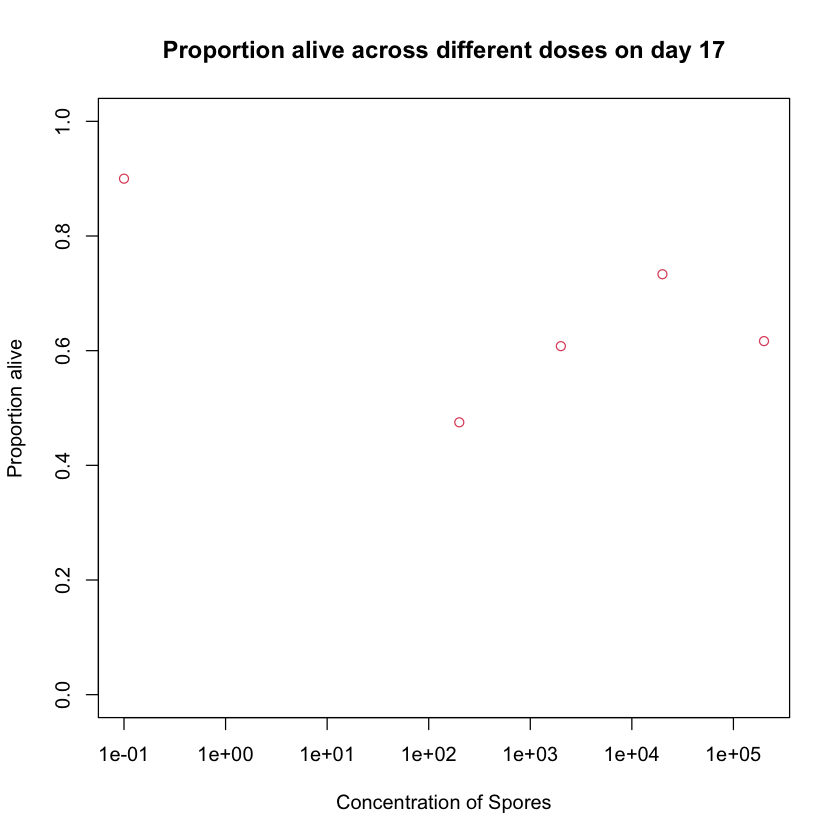

In [34]:
# NAs in the output suggest we're not looking at a dose response relationship, which is typically sigmoidal
# let's plot to see what is going wrong
plot(dose.pot.sum$day_17 ~ c(0.1, 200, 2000, 20000, 200000), log= "x", ylim = c(0, 1.0), 
     xlab = "Concentration of Spores", ylab = "Proportion alive", col = 10, 
     main = "Proportion alive across different doses on day 17")

In [35]:
# So, it is clear from the experiment that Nosema does kill bees (significant hazard ratios in coxph),
# however, this lethal effect is clearly not in the form of a dose response relationship, as all the doses
# had pretty much the same level of survival.